## Graph Neural Networks with Pytorch Geometric

Author: [Savannah Thais](https://github.com/savvy379)

First portion (Cora dataset) adapted from the [Pytorch Geometric Tutorial](https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html)

Introduction
This notebook teaches the reader how to build Graph Neural Networks (GNNs) with Pytorch Geometric (PyG). The first portion walks through a simple GNN architecture applied to the Cora Dataset; it is a modified version of the PyG [Tutorial](https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html) on node classifying GNNs. The second portion introduces a GNN-based charged particle tracking pipeline based on ["Charged particle tracking via edge-classifying interaction networks"](https://arxiv.org/abs/2103.16701).

A graph $G$ is a mathematical object consisting of a set of nodes (vertices) $N$ and edges $E$, $G=(N,E)$. Graphs can easily represent a wide range of structured data including atoms in molecules, users in a social network, cities and roads in a transportation system, players in team sports, objects interacting in a dynamical physical system, detector events , and more. The nodes and edges of the graph can have associated features as defined by the developer; these can include geometric information (ie particle hit locations in a detector) and non-geometric information (ie particle momenta). Graphs can be directed or undirected. A major advantage of GNNs is that they can handle input data of varying sizes: each graph processed by the network can have a different number of nodes and edges, making them well suited for a range of HEP applications as shown below for (a) particle tracking, (b) calorimeter clustering, (c) event classification, and (d) jet tagging (image from [Graph Neural Networks in Particle Physics](https://iopscience.iop.org/article/10.1088/2632-2153)).

![](https://drive.google.com/uc?id=1dGIKhsfeI7-Ik3pXL8t5Dsb6UyDohMiM)

In general, GNNs work by leveraging local information across the graph structure to intelligently re-embed the edges and nodes. A commonly used class of GNNs (and the focus of this tutorial) is the Graph Convolutional Network (GCN). GCNs use the same convolution operations as in a normal CNN, but apply the convolutions to node neighborhoods rather than a fixed data tensor (like an image matrix). These are considered a type of "Message Passing Network" when are 'message' is constructed by combining and transforming information from neighboring nodes and that message is 'passed' to a target node and used to update its features. In this way the entire graph can be transformed such that each node is updated to include additional useful information. The convolved graph is typically then processed by an additional linear layer that uses node and or edge features to do classification or regression on individual graph elements, graph substructures, or the graph as a whole. (Note: the same message passing structure can be applied to edges instead of nodes to update edge features as well). 

![](https://drive.google.com/uc?id=1f5MJO9Kw1tWjJMBJBsZ-M4tMFz_dydr2)

In mathematical terms, a single graph convolution layer can be described as: 

![](https://drive.google.com/uc?id=1hj82TSiKTwKTX9IFfpYRG7qygtSAAw6A)

Here, $h_v^0$ is the initial embedding of node $v$ (ie the original node features). To update the embedding of node $v$, $h_v^k$, the 'message' is constructed by applying a function $f$ to a the average over the current embedding of all the neighboring nodes (nodes connected to $v$ by a graph edge): $N(v)$) $\sum_{u \in N(v)}\frac{h_u^{k-1}}{deg(v)}$ and, optionally, the current embedding of the target node: $h_v^{k-1}$ then passed through a non-linear activation function and used to update the target node. In practice the functions $f$ is approximated by a matrix (convolution) $W_k$ with the added non-linearity of the activation function.   

This entire process is visualized in the below diagram, taken from the excellent paper [A Practical Guide to Graph Neural Networks](https://arxiv.org/abs/2010.05234).

![](https://drive.google.com/uc?id=1wKbb_pDP0pK8BFmA6Bxn4jvifs0nucd6)

# Coding!

## Part 1: Graph Node Classifaction with Cora

#### The Dataset

In the first part of this tutorial we will use the [Cora dataset](https://relational.fit.cvut.cz/dataset/CORA) to predict the subject of a research paper given its words and citation network. The cora dataset consists of 2,708 scientific papers with a unique id classified into one of 7 classes. The citation network consists of 5,429 links. Each paper has an associated binary word vector of size 1,433 indiating the presence of correpsonding word fromt he pre-defined dictionary. 

We'll start with some simple EDA to get familar with the dataset. In it's raw format, the dataset cnotains two tab-separated files: `cora.cites` and `cora.content`. The cites file includes all pairs of citation records formulated as two columns: `cited_paper_id` (target) and `citing_paper_id` (source). The content file includes the paper content recors with 1,435 columns: `paper_id`, `subject` (training target), and 1,433 binary features corresponding to the binary word vector. 

Let's go!

In [12]:
## mount your google drive so we can access the data from github
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
cd /content/drive/MyDrive/Github/codashep_ml_2022/

/content/drive/MyDrive/Github/codashep_ml_2022


In [1]:
## SETUP
# Install required packages.
import os
import torch
import pandas as pd
import numpy as np
import networkx as nx
import tensorflow as tf ## we're just using this for the EDA
from tensorflow import keras
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

1.12.0+cu113
     |████████████████████████████████| 7.9 MB 3.4 MB/s 
     |████████████████████████████████| 3.5 MB 3.6 MB/s 


In [ ]:
#download the raw data
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

180224/168052 [================================] - 0s 1us/step


To start our EDA we'll load the cites data into a dataframe and get the shape. We expect it to be 5429x2, representing 5429 linked paper pairs.

In [ ]:
#load the cites data into a dataframe and get the shape (expect it to be 5429x2, representing 5429 linked paper pairs)
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Citations shape: (5429, 2)


We can also take a look at the beginning of the dataset

In [ ]:
citations.head()

,target,source
0,35,1033
1,35,103482
2,35,103515
3,35,1050679
4,35,1103960


The first few lines are listing the papers that reference paper ID 35.

Now we'll load the papers data and get the shape and take a look at the first few entries. We expect this df to be 2708x1435: 2708 unique papers and their associated topic and word binaries. 

In [ ]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Papers shape: (2708, 1435)


In [ ]:
print(papers.sample(5).T)

                      832         96                     2375  \
paper_id             66986     1110947                 632874   
term_0                   0           0                      0   
term_1                   0           1                      0   
term_2                   0           0                      0   
term_3                   0           0                      0   
...                    ...         ...                    ...   
term_1429                0           0                      0   
term_1430                0           0                      0   
term_1431                0           0                      0   
term_1432                0           0                      0   
subject    Neural_Networks  Case_Based  Probabilistic_Methods   

                      527                    2384  
paper_id            120084                 180301  
term_0                   0                      0  
term_1                   0                      0  
term_2     

We can also look at the count of papers in each subject:

In [ ]:
print(papers.subject.value_counts())

Neural_Networks           818
Probabilistic_Methods     426
Genetic_Algorithms        418
Theory                    351
Case_Based                298
Reinforcement_Learning    217
Rule_Learning             180
Name: subject, dtype: int64


We can use the `networkx` package to visualize a subset of the papers in the citation graph format. Each node will represent an idividual paper, nodes will be connected by an edge if one paper cites the other, and the color of each node will represent subject area.

First we'll do a little transformatio on the dataset to make it easier to plot. We'll convert the paper ids and subjects into zero-based indices. The papers will be indexed starting from 0 and the paper subjects will be represented by a value between 0 and 7, correpsonding to the subject classes.

In [ ]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

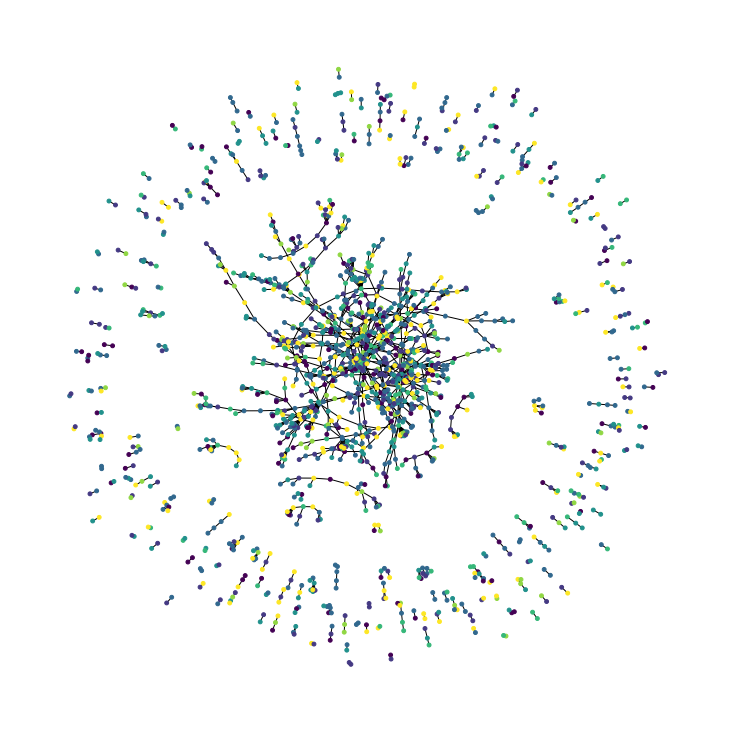

In [ ]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)

We can see many small citation clusters on the outside of the graph consisting of a few papers typically all in one or two subjects, and a large, interconnected subgraph in the center where many different papers are connected through a citation chain. Let's see if we can use this graph to learn to predict the subject area of different papers! 

### Building a GNN 
First, we'll re-download the Cora dataset in a PyG friendly format

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

Processing...
Done!


We can easily get some summary information about the dataset

In [ ]:
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Has isolated nodes: False
Has self-loops: False
Is undirected: True


We see it is identical to the raw txt file format: 2708 nodes (papers), 10556 edges (5278 citation pairs*), 1433 node features (word embedings), and 1 node label (paper subject). The dataset provides `val` and `test` masks to create subsets of nodes to act as training and validation datasets. For training, we are given the ground-truth categories of 140 nodes (20 for each class).
This results in a training node label rate of 5%.

**Note:** The graph construction used in this version of the dataset is actually slightly different than the raw data (originally 5429 citation pairs). Here they form an undirected graph, ie they create two edges between each citation pair, removing allowing information to flow both ways but eliminating information about which paper cites which (directed edges). 

We can construct a GNN in PyG very similary to how we build a standard feed-forward neural network. We just need to swap the `torch.nn.Linear` layers with PyG's GNN operators. 

In particular, we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information. The construction of the local neighborhood is handled by the `GCNConv` layer definition within PyG.

Let's set up our model!


In [ ]:
from torch_geometric.nn import GCNConv
import torch.nn.functional as F

## just like with regular NNs in Pytorch we need to define the layer structure of our GNN and the forward propagation of the network 
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        ## our GNN will have two graph convolution layers, one that re-embeds each node into the number of hidden channels, and one that
        ## predicts the class label (by re-embedding each node into 7 dimensions)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

GCN(
  (conv1): GCNConv(1433, 16)
  (conv2): GCNConv(16, 7)
)


Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane. Each node is colored according to its true subject label.

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


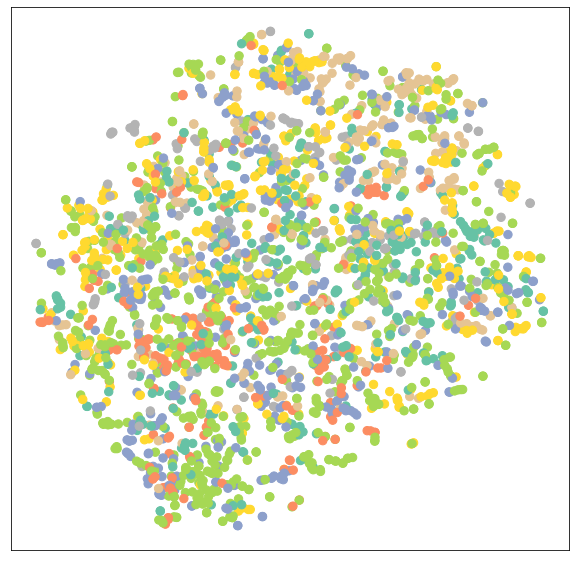

In [ ]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

Now we can train our model! Again, the process is very similar to training a standard NN, but this time we make use of the node features `x` **and** the graph connectivity `edge_index` as input to our GCN model.

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

<IPython.core.display.Javascript object>

Epoch: 001, Loss: 1.9463
Epoch: 002, Loss: 1.9409
Epoch: 003, Loss: 1.9343
Epoch: 004, Loss: 1.9275
Epoch: 005, Loss: 1.9181
Epoch: 006, Loss: 1.9086
Epoch: 007, Loss: 1.9015
Epoch: 008, Loss: 1.8933
Epoch: 009, Loss: 1.8808
Epoch: 010, Loss: 1.8685
Epoch: 011, Loss: 1.8598
Epoch: 012, Loss: 1.8482
Epoch: 013, Loss: 1.8290
Epoch: 014, Loss: 1.8233
Epoch: 015, Loss: 1.8057
Epoch: 016, Loss: 1.7966
Epoch: 017, Loss: 1.7825
Epoch: 018, Loss: 1.7617
Epoch: 019, Loss: 1.7491
Epoch: 020, Loss: 1.7310
Epoch: 021, Loss: 1.7147
Epoch: 022, Loss: 1.7056
Epoch: 023, Loss: 1.6954
Epoch: 024, Loss: 1.6697
Epoch: 025, Loss: 1.6538
Epoch: 026, Loss: 1.6312
Epoch: 027, Loss: 1.6161
Epoch: 028, Loss: 1.5899
Epoch: 029, Loss: 1.5711
Epoch: 030, Loss: 1.5576
Epoch: 031, Loss: 1.5393
Epoch: 032, Loss: 1.5137
Epoch: 033, Loss: 1.4948
Epoch: 034, Loss: 1.4913
Epoch: 035, Loss: 1.4698
Epoch: 036, Loss: 1.3998
Epoch: 037, Loss: 1.4041
Epoch: 038, Loss: 1.3761
Epoch: 039, Loss: 1.3631
Epoch: 040, Loss: 1.3258


And we can check the test set accuracy

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.8150


Not perfect, but it's pretty accurate at predicting paper subject area!

We can further verify that  by looking at the output embeddings of our **trained** model, which now produces a far better clustering of nodes of the same category.



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


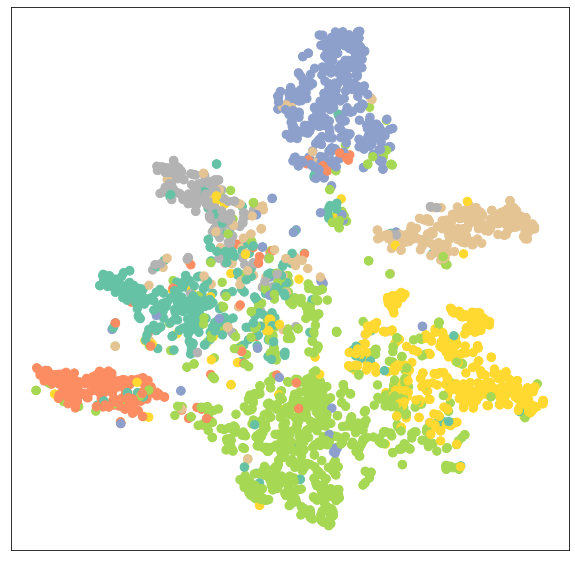

In [ ]:
model.eval()

out = model(data.x, data.edge_index)
visualize(out, color=data.y)

### Wrap Up
Nice! We've used PyG to build an effective GNN that re-embeds the initial Cora dataset graph into a space more useful for node label prediction. This is a just one of the many available GNN architectures and only one of the possible graph prediction tasks; other common tasks include edge classification (coming up next!) and graph classification (check out this [tutorial]( https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb?usp=sharing)), among others. 

### (Optional) Exercises

1. To achieve better model performance and to avoid overfitting, it is usually a good idea to select the best model based on an additional validation set.
The `Cora` dataset provides a validation node set as `data.val_mask`, but we haven't used it yet.
Can you modify the code to select and test the model with the highest validation performance?
This should bring test performance to **82% accuracy**.

2. How does `GCN` behave when increasing the hidden feature dimensionality or the number of layers?
Does increasing the number of layers help at all?

3. You can try to use different GNN layers to see how model performance changes. What happens if you swap out all `GCNConv` instances with [`GATConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv) layers that make use of attention? Try to write a 2-layer `GAT` model that makes use of 8 attention heads in the first layer and 1 attention head in the second layer, uses a `dropout` ratio of `0.6` inside and outside each `GATConv` call, and uses a `hidden_channels` dimensions of `8` per head.

## Part Two: Edge Classification for Charged Particle Tracking

### Introduction

Now we'll turn to an actual physics example! We'll be using GNNs for charged particle tracking. This tutorial is based on the paper ["Charged particle tracking via edge-classifying interaction networks"](https://arxiv.org/abs/2103.16701) by DeZoort et al, however there is much excellent work exploring GNNs for tracking (see also [ExaTrkX](https://exatrkx.github.io/)) and other reconstruction and analysis tasks in HEP (see the recent paper ["Graph Neural Networks in Particle Physics: Implementations, Innovations, and Challenges"](https://arxiv.org/abs/2203.12852)). 

Charged particle tracking can be thought of as the problem of 'connecting the dots' where the 'dots' are hits in the tracker of a particle detector. The goal is to identify which hits belong to an individual particle trajectory, group them together, and fit the path to extract particle kinematics like momentum. 

![](https://drive.google.com/uc?id=13JSzVGs4YJxV6DSlSXT7ZayT5oQZevkq)

This task can be represented naturally as a graph-based problem. Beginning with a point cloud of tracker hits, one can construct a graph by building edges (potential track segments) between the hits, process the graph with an edge-classifying GNN to identify if an edge is a true track segment or a noise edge, and then link the positively identified edges together to form track candidates (that would then be fit). 

![](https://drive.google.com/uc?id=1eHLlvmCCs0rz2YGcq4ZSncRB1TizQTFG)



In [11]:
pd.read_csv('lecture4_gnns/trackml/event000000200-cells.csv')

,hit_id,ch0,ch1,value
0,1,130,581,0.296919
1,2,91,640,0.330281
2,3,33,593,0.205953
3,3,33,592,0.104593
4,4,319,948,0.267789
...,...,...,...,...
638204,116140,515,6,1.000000
638205,116141,719,6,1.000000
638206,116141,716,6,1.000000
638207,116141,717,6,1.000000
